<span style="color:blue"><font size="6">**Прогноз оттока клиентов и план действий по удержанию клиентов сети фитнес-центров**</span>
    
    
## Описание проекта
    
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами. Для этого отдел по работе с клиентами перевел множество клиентских анкет в электронный вид. Заказчик подготовил данные, которые содержат информацию на месяц до оттока и факт оттока на определенный месяц. Необходим их анализ для построения плана по удержанию клиентов.
    
    
<span style="color:red">**Цель исследования:**</span> 
    
Провести анализ анкет клиентов сети фитнес-центров и разработать рекомендации по их удержанию.
    

    
<span style="color:red">**Задачи:**</span> 
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
2. Определить типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
3. Проанализировать основные признаки, наиболее сильно влияющие на отток клиентов
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами
    


**Описание данных:**
* **Данные клиента за предыдущий до проверки факта оттока месяц:**
 - 'gender' — пол;
 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
 - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент     в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате       первого абонемента);
 - 'Phone' — наличие контактного телефона;
 - 'Age' — возраст;
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);
 
 
* **Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 - 'Group_visits' — факт посещения групповых занятий;
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
 

* **'Churn' — факт оттока в текущем месяце.**

##  Загрузка данных

In [1]:
# импортируем необходимые бибилиотеки
import pandas as pd     
import numpy as np                            
import seaborn as sns                          
import matplotlib.pyplot as plt
import plotly.express as px
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
# создадим функцию для отображения общей информации о таблице, пропусках и явных дубликатах
def df_info(df):
    pd.set_option("max_colwidth", 150)
    display(df.head())
    print(' ')
    df.info()
    print(' ')
    print('\033[1m' + 'Пропуски в таблице:' + '\033[0m')
    display(df.isna().sum())
    print('\033[1m' + 'Количество дубликатов в таблице:' + '\033[0m', df.duplicated().sum())

In [4]:
gym = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')
df_info(gym)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   flo

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Количество дубликатов в таблице: 0


**В таблице представлены 4000 записей. Столбец 'Month_to_end_contract' необходимо привести к целочисленному типу данных. Наименования столбцов необходимо будет привести к единому стилю. Пропущенные значения и дубликаты не найдены.**

##  Предобработка данных

In [4]:
# приведем наименования столбцов к единому виду
gym.columns = gym.columns.str.lower()

# приведем столбец со сроком окончания абонемента к типу int
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype(int)
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

##  Исследовательский анализ данных

In [5]:
# на этапе изучения данных пропуски не были обнаружены, посмотрим средние значения и стандартные отклонения
gym.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


**По описательным данным:**
* Клиентами фитнес-центра являются как женщины, так и мужчины, примерно в равном соотношении
* Средний возраст клиентов - 29 лет
* Большинство клиентов живет или работает рядом с фитнес-цетром
* Менее 50% клиентов являются сотрудниками компании-партнера
* Около 31% клиентов записались в фитнес-центр в рамках акции "Приведи друга"
* Около 90% клиентов указали мобильный телефон
* Большинство клиентов приобретают абонемент на 1 месяц, при этом средняя длительность текущего действующего абонемента 4,6 месяцев
* 41% клиентов предпочитает групповые занятия
* Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
* У большинства клиентов срок до окончания текущего действующего абонемента составляет 1 месяц, при этом средний срок - 4,3 месяцев.
* Среднее время с момента первого обращения в фитнес-центр - более 3 месяцев
* Средняя частота посещений за неделю за все время - 1,9
* Средняя частота посещений за неделю за предыдущий месяц - 1,8
* Более 70% клиентов остаются заниматься в фитнес-центре

In [6]:
# теперь посмотрим на средние значения в зависимотси от того, ушел клиент или остался
gym.groupby('churn').mean().round(2).T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


**Разделив клиентов на группы в зависимости от того, посещает ли клиент фитнес-центр (действующий клиент) или прекратил посещать (отток), средние значения таковы:**
* Мужичны и женщины в равном соотношении что в группе "отток", что в группе действующих клиентов
* Средний возраст клиентов из группы "отток" около 27 лет, в то время как в группе действующих - около 30 лет
* В обеих группах большинство клиентов живет или работает рядом с фитнес-цетром
* Более 50% клиентов являются сотрудниками компании-партнера в группе действующих клиентов, в группе "отток" - 36%
* 35% из группы действующих клиентов записались в фитнес-центр в рамках акции "Приведи друга", в группе "оттток" таких клиентов всего лишь 18%
* В обеих группах 90% клиентов указали мобильный телефон
* Большинство клиентов из группы "отток" приобретают абонементы на 1 месяц, в то время как клиенты из второй группы предпочитают более долгосрочные абонементы - 6 месяцев
* Групповым занятиям отдают предпочтение действующие клиенты
* Средняя суммарная выручка от других услуг фитнес-центра группы "отток - 115 у.е., группы действующих клиентов - 158 у.е.
* У большинства клиентов группы действующих клиентов срок до окончания текущего действующего абонемента составляет более 5  месяцев, средний срок группы "оттока" - чуть более 1 месяца.
* Среднее время с момента первого обращения в фитнес-центр группы действующих клиентов - более 4 месяцев, группы "отток" - 1 месяц
* Средняя частота посещений за неделю за все время группы действующих клиентов - 2, группы "отток" - 1,5
* Средняя частота посещений за неделю за предыдущий группы действующих клиентов - 2, группы "отток" - 1

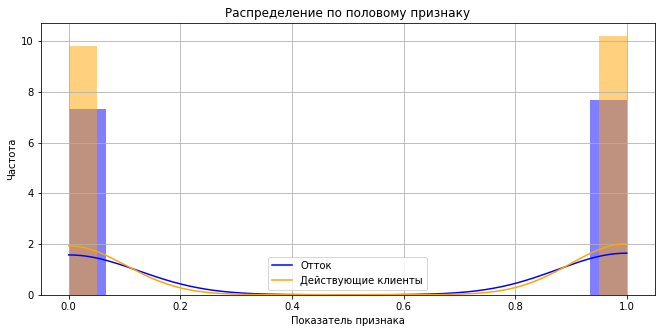

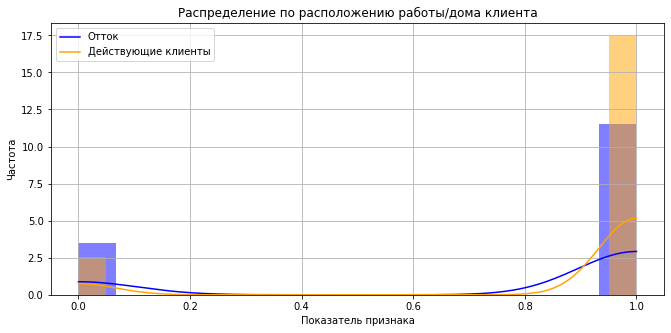

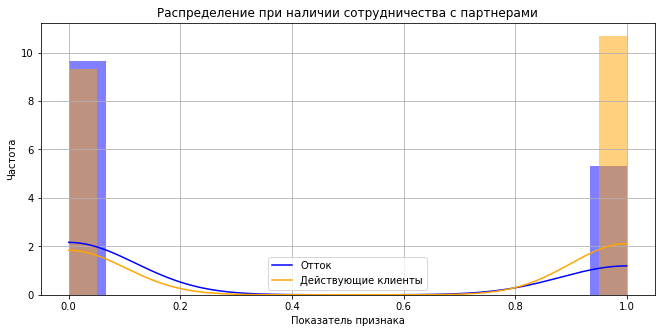

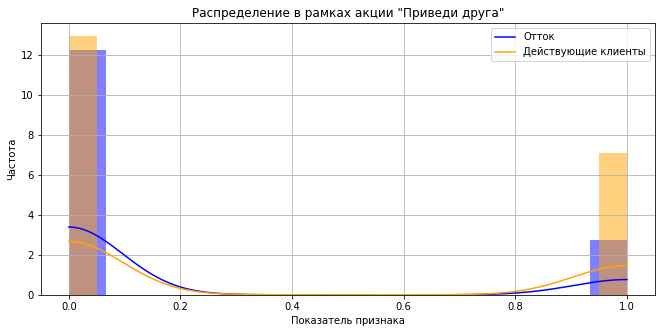

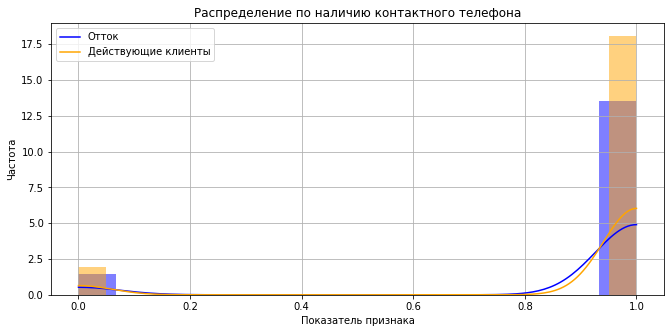

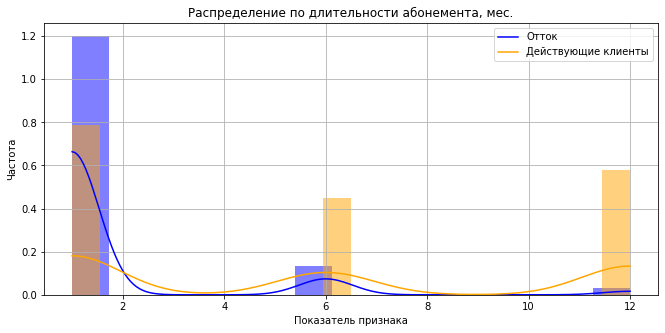

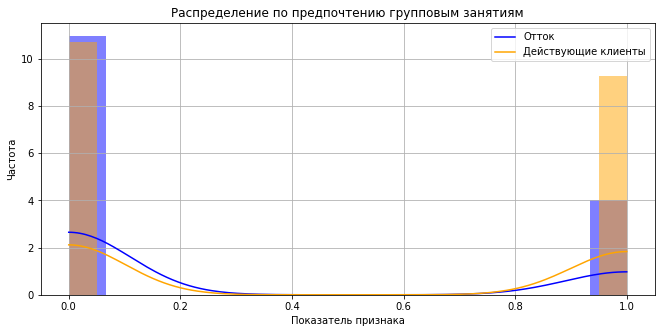

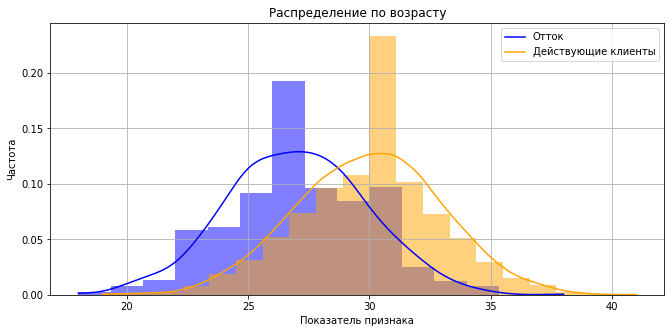

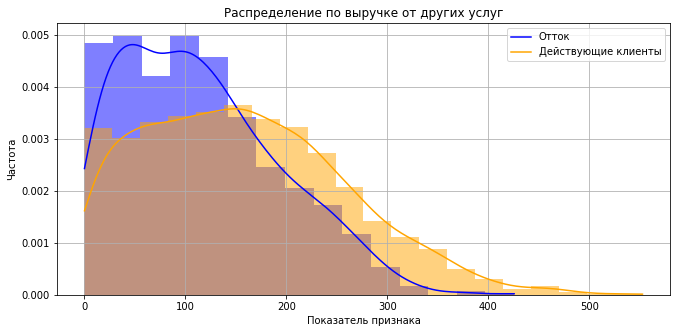

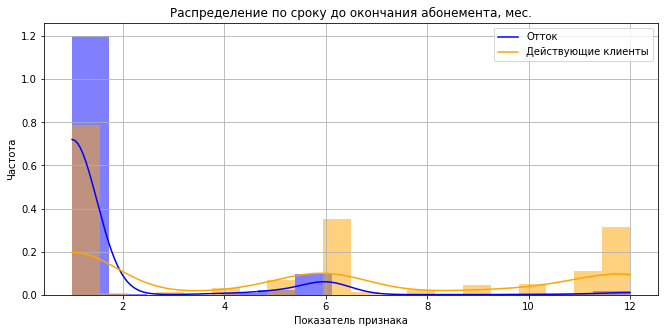

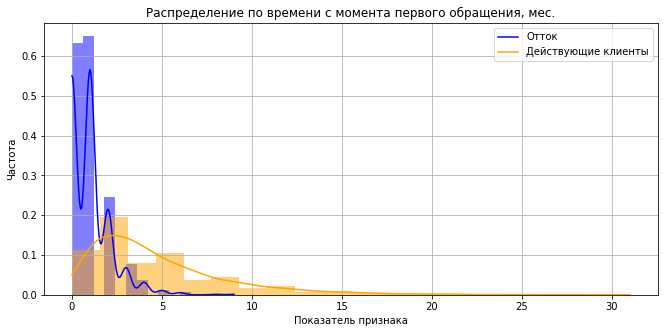

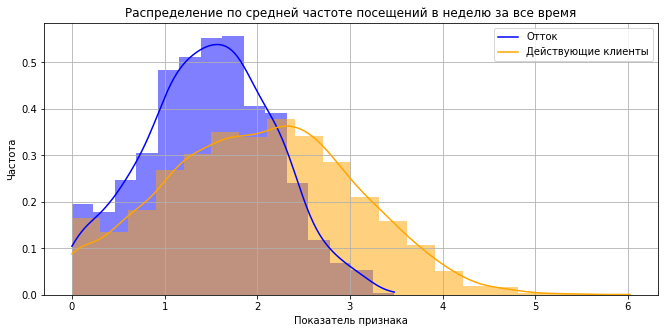

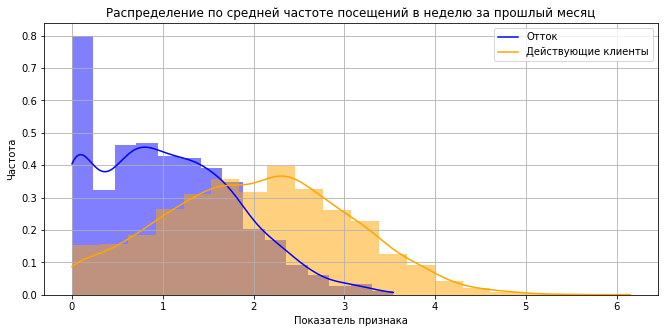

In [7]:
# разделим датасет на группы: "отток" и "действующие клиенты". Построим графики по каждому признаку
group_churn = gym.query('churn == 1')
group_stay = gym.query('churn == 0')

gym_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

# зададим список с названиями графиков
title_plot = ['Распределение по половому признаку', 'Распределение по расположению работы/дома клиента',\
              'Распределение при наличии сотрудничества с партнерами', 'Распределение в рамках акции "Приведи друга"',\
              'Распределение по наличию контактного телефона', 'Распределение по длительности абонемента, мес.',\
              'Распределение по предпочтению групповым занятиям', 'Распределение по возрасту', 'Распределение по выручке от других услуг',\
             'Распределение по сроку до окончания абонемента, мес.', 'Распределение по времени с момента первого обращения, мес.',\
             'Распределение по средней частоте посещений в неделю за все время', 'Распределение по средней частоте посещений в неделю за прошлый месяц']
count = 0

# через цикл построим графики по каждой группе и каждому признаку
for column in gym_columns:
    plt.figure(figsize=(11,5))
    plt.title(title_plot[count])
    count = count + 1
    sns_plot_1 = sns.histplot(group_churn[column], bins = 15, color='blue', kde=True, stat="density", linewidth=0)
    fig_1 = sns_plot_1.get_figure()
    sns_plot_2 = sns.histplot(group_stay[column], bins = 20, color='orange', kde=True, stat="density", linewidth=0)
    fig_2 = sns_plot_2.get_figure()
    plt.ylabel('Частота')
    plt.xlabel('Показатель признака')
    plt.legend(['Отток', 'Действующие клиенты'])
    plt.grid()
    plt.show()

**Исходя из графиков, можно отметить:**

* Различий по половому признаку между группами "отток" и "действующие клиенты" не наблюдается.
* В группе "отток" клиентов, которые живут/работают не рядом с фитнес-центром больше, чем в группе "действующие".
* Большинство клиентов, которые относятся к группе "отток" не являются сотрудниками компании-партнера.
* Большинство клиентов, которые относятся к группе "отток" пришли в фитнес-клуб не по акции "Приведи друга", доля клиентов по акции из группы "действующие клиенты" в разы выше.
* Рапсределение по наличию контактного номера между группами примерно одинаково.
* У большинства клиентов группы "отток" длительность абонемента составляла 1 месяц. Лишь 20-25% клиентов попавших в "отток" приобретали абомененты длительностью больше 6 месяцев.
* Высока доля "действующих клиентов", которые посещали групповые занятия, клиенты из "оттока" не часто отдавали предпочтение групповым занятиям.
* Средний возраст клиентов группы "отток" - 27 лет, клиентов группы "действующие клиенты" -  30 лет.
* Средняя суммарная выручка от других услуг фитнес-центра выше у "действующих клиентов".
* У большинства клиентов группы "отток" срок до окончания абонемента составлял менее 2-х месяцев. У "действующих клиентов" чаще всего срок до окончания абонемента также 1-2 месяца, при этом также значительна доля клиентов со сроком онончания - 6-12 месяцев.
* Время с момента первого обращения в фитнес-центр у клиентов группы "отток" составляет 1-2 месяца, у "действующих клиентов" - 3 месяцев.
* Клиенты группы "отток" за все время чаще всего посещали фитнес-центр 1 раз в неделю, "действующие клиенты" посещали фитнес-клуб чаще, не менее 2 раз в неделю.
* Клиенты группы "отток" за прошлый месяц чаще всего либо не посещали фитнес-центр, либо 1 раз в неделю, "действующие клиенты" посещали фитнес-клуб чаще, более 2 раз в неделю.

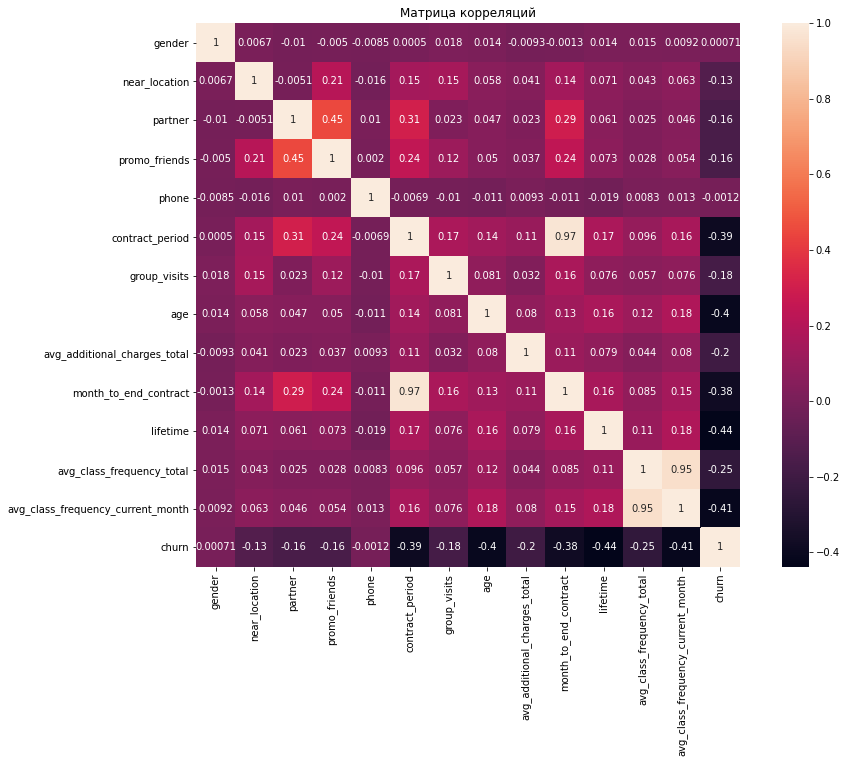

In [8]:
# построим матрицу корреляций, посмотрим есть ли эффект мультиколлинеарности
cm = gym.corr()

plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

**По матрице корреляции:**

1. Выбивающего признака, который имел бы высокую степень корреляции не обнаружено. Все признаки имеют либо слабо, либо умеренно отрицательную связь.


2. Обнаружены признаки, которые сильно коррелируют между собой:
   * 'month_to_end_contract' и 'contract_period'
   * 'avg_class_frequency_total' и 'avg_class_frequency_current_month'

**Выводы исследовательского анализа:** 
    
1. В группу "отток" чаще всего попадают клиенты до 27 лет, которые купили абонемент всего на 1 месяц, либо у которых остался всего месяц до окончания абонемента, вероятнее всего данные клиенты живут/работают не рядом с фитнес-центром, не являются сотрудниками компании-партнера и возможно пришли впервые в фитнес-клуб не позже 1-2 месяцев назад. Данные клиенты не предпочитают групповые занятия и в среднем посещают фитнес-центр не чаще 1 раза в неделю.


2. В результате анализа матрицы корреляций выбивающего признака, который имел бы высокую степень корреляции не обнаружено, однако, были обнаружены 2 пары признаков с очень высокой корреляцией:
 * 'month_to_end_contract' и 'contract_period'(0,97)
 * 'avg_class_frequency_total' и 'avg_class_frequency_current_month'(0,95)

##  Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где *целевой признак — факт оттока клиента в следующем месяце*. 

Обучим модель 2 способами: логистической регрессией и случайным лесом, оценим метрики обеих моделей и выберем лучшую модель.

In [9]:
X = gym.drop('churn', axis=1)
y = gym.churn

#разделим модель на обучающую(80%) и валидационную выборки(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#стандартизируем данные и обучаем
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st =  scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим список моделей: логистическая регрессия, слуйчайный лес
models = [LogisticRegression(), RandomForestClassifier()]

# напишем функцию, которая принимает на вход модель и данные, а выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall:{:.3f}'.format(
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
        )
    )
    
# напишем цикл, который выводит метрики по списку моделей
for i in models:
    print('')
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)


LogisticRegression()
Accuracy: 0.935
Precision: 0.896
Recall:0.854

RandomForestClassifier()
Accuracy: 0.922
Precision: 0.883
Recall:0.816


**Несмотря на то, что метрики не сильно различаются в показателях у обеих моделей, все же модель логистической регрессии (LogisticRegression) имеет более высокое качество прогнозирования. Все метрики по данной модели показали чуть лучше результат.**

##  Кластеризация клиентов

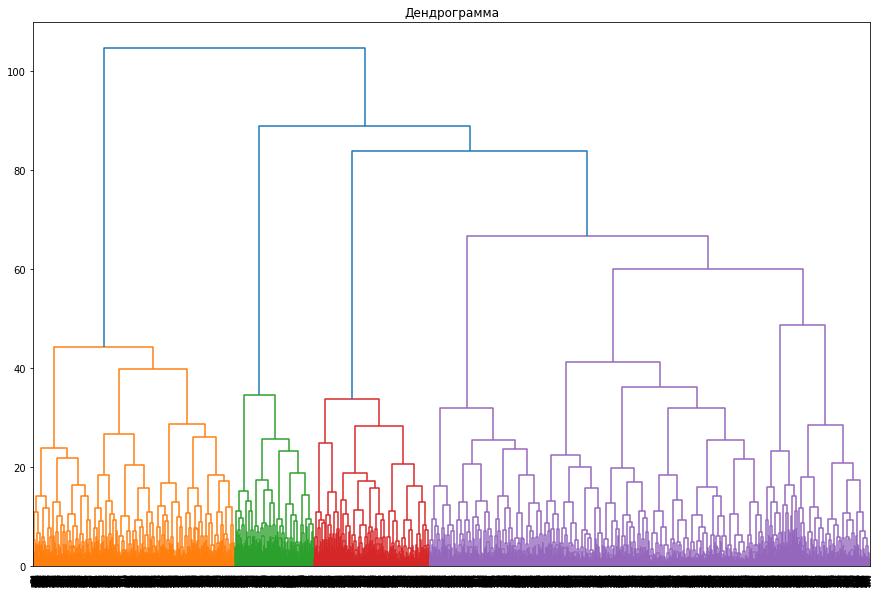

In [10]:
# построим матрицу расстояний и нарисуем дендрограмму
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method='ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show() 

**По данным графика выделены 4 кластера.**

In [11]:
# обучим модель кластеризации на основании алгоритма K-Means, примем число кластеров = 5
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
gym['cluster_km'] = labels

# выводим статистику по средним значениям признаков по кластеру
display(gym.groupby('cluster_km').mean().T)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


**По средним значениям признаков по каждому кластеру можно отметить:**

**1. Клиенты из *Кластера 0*:**
* живут/работают рядом с фитнес-центром
* большинство является сотрудниками компании-партнера
* большинство пришли по акции "Приведи друга"
* указали номер телефона
* большинство приобрели долгосрочные абонементы
* предпочитают групповые занятия
* средний возраст - 30 лет
* средняя сумма выручки по другим услугам - 161 у.е.
* большой срок до окончания абонемента
* 4-5 месяцев с момента первого обращения в фитнес-центр
* в среднем посещают 2 раза в неделю за все время
* низкий процент оттока - 2,8%

**2. Клиенты из *Кластера 1*:**
* живут/работают рядом с фитнес-центром
* большинство не является сотрудниками компании-партнера
* не участвовали в акции "Приведи друга"
* не указали номер телефона
* большинство приобрели абонементы до 6 мес.
* не предпочитают групповые занятия
* средний возраст - 29 лет
* средняя сумма выручки по другим услугам - 144 у.е.
* средний срок до окончания абонемента - 4 мес.
* 4 месяца с момента первого обращения в фитнес-центр
* в среднем посещают 1,8 раз в неделю за все время и 1,7 за прошлый месяц
* средний процент оттока - 26,7%

**3. Клиенты из *Кластера 2*:**
* живут/работают не рядом с фитнес-центром
* большинство не является сотрудниками компании-партнера
* не участвовали в акции "Приведи друга"
* указали номер телефона
* большинство приобрели краткосрочные абонементы
* не предпочитают групповые занятия
* средний возраст - 28 лет
* средняя сумма выручки по другим услугам - 135 у.е.
* средний срок до окончания абонемента - 2 мес.
* 2-3 месяца с момента первого обращения в фитнес-центр
* в среднем посещают 1,6 раз в неделю за все время и 1,4 за прошлый месяц
* высокий процент оттока - 44,4%

**4. Клиенты из *Кластера 3*:**
* живут/работают рядом с фитнес-центром
* большинство не является сотрудниками компании-партнера
* не участвовали в акции "Приведи друга"
* указали номер телефона
* большинство приобрели краткосрочные абонементы
* не предпочитают групповые занятия
* средний возраст - 28 лет
* средняя сумма выручки по другим услугам - 132 у.е.
* средний срок до окончания абонемента - 1-2 мес.
* 2 месяца с момента первого обращения в фитнес-центр
* в среднем посещают 1 раз в неделю за все время
* самый высокий процент оттока - 51,4%

**5. Клиенты из *Кластера 4*:**
* живут/работают рядом с фитнес-центром
* большинство не является сотрудниками компании-партнера
* не участвовали в акции "Приведи друга"
* указали номер телефона
* большинство приобрели краткосрочные абонементы
* не предпочитают групповые занятия
* средний возраст - 30 лет
* средняя сумма выручки по другим услугам - 162 у.е.
* средний срок до окончания абонемента - 2-3 мес.
* 4-5 месяца с момента первого обращения в фитнес-центр
* в среднем посещают 3 раз в неделю за все время
* низкий процент оттока - 6,8%

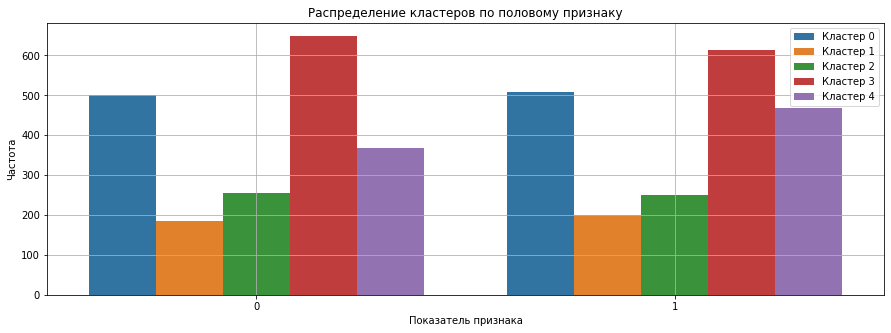

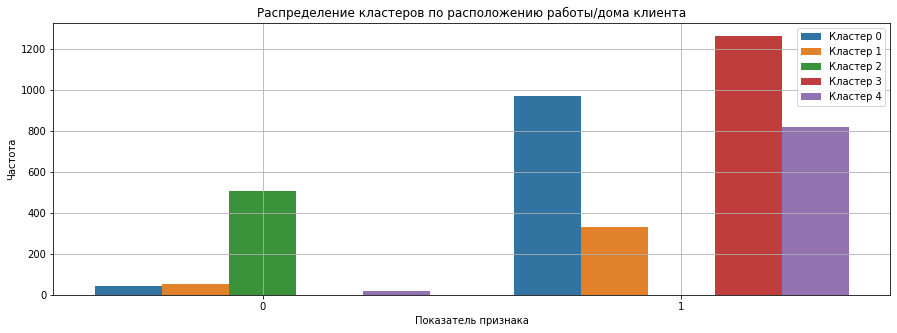

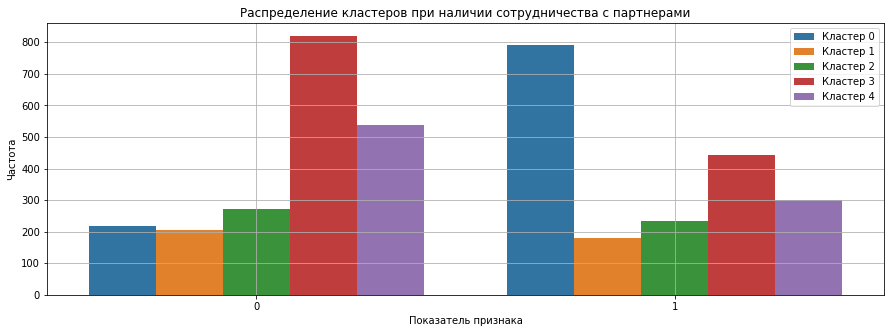

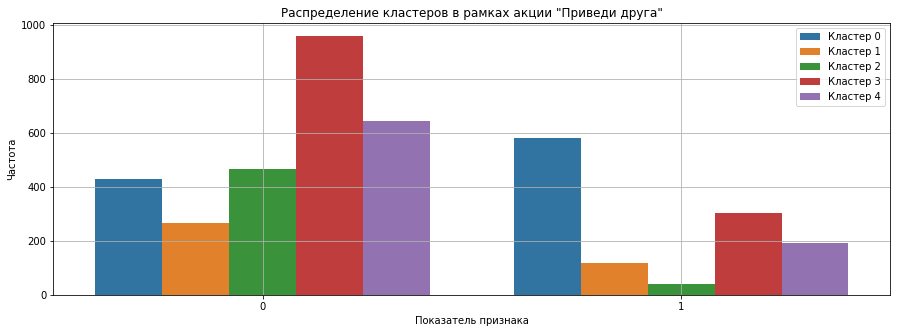

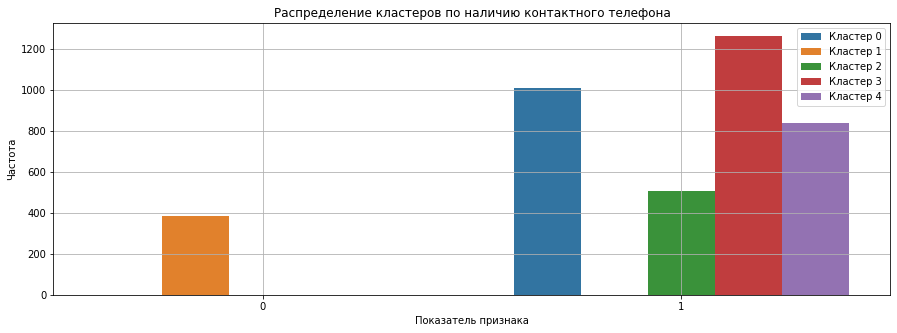

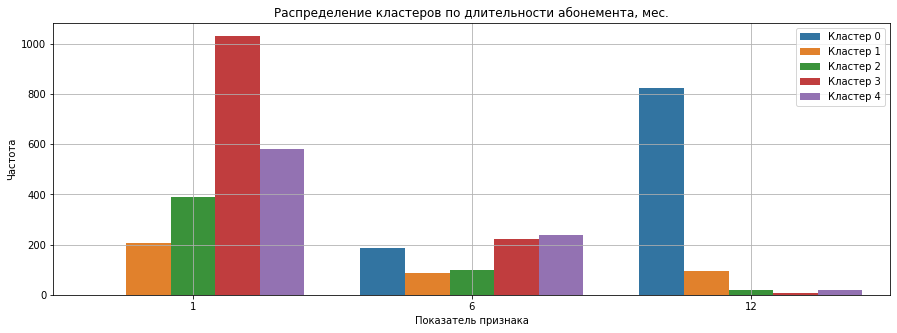

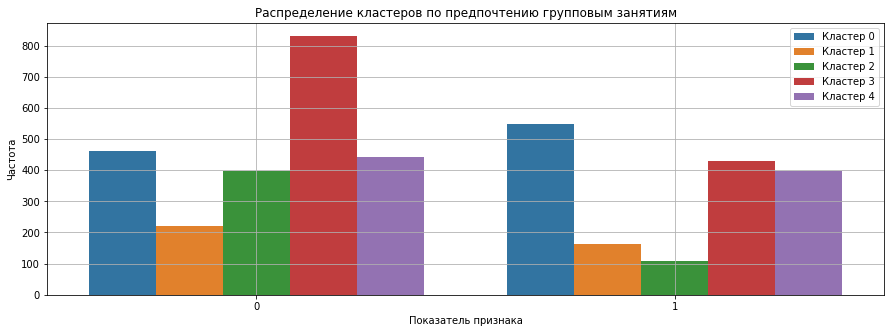

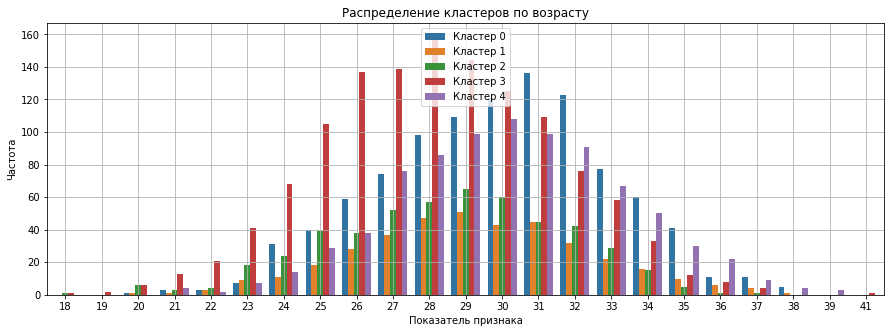

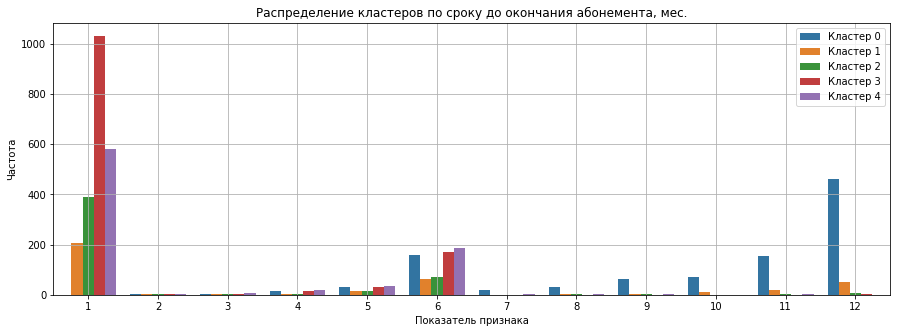

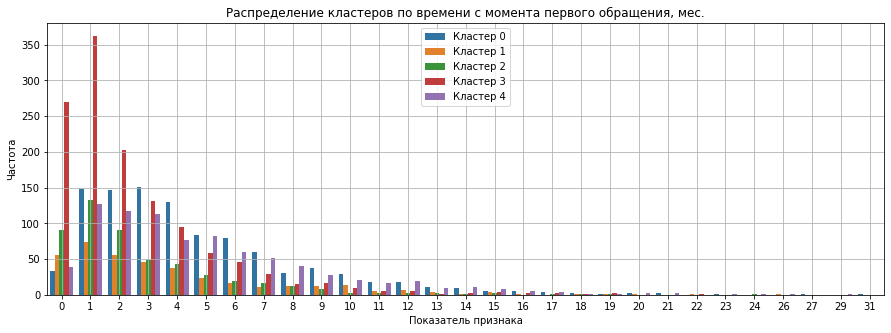

In [12]:
# визуализируем распределение признаков по кластерам
# зададим список с признаками и названиями графиков
gym_columns1 = ['gender', 'near_location', 'partner', 'promo_friends', 'phone','contract_period', 'group_visits',\
                'age', 'month_to_end_contract', 'lifetime']


title_plot1 = ['Распределение кластеров по половому признаку', 'Распределение кластеров по расположению работы/дома клиента',\
              'Распределение кластеров при наличии сотрудничества с партнерами', 'Распределение кластеров в рамках акции "Приведи друга"',\
              'Распределение кластеров по наличию контактного телефона', 'Распределение кластеров по длительности абонемента, мес.',\
              'Распределение кластеров по предпочтению групповым занятиям', 'Распределение кластеров по возрасту',\
             'Распределение кластеров по сроку до окончания абонемента, мес.', 'Распределение кластеров по времени с момента первого обращения, мес.']
count1 = 0

for column in gym_columns1:
    plt.figure(figsize=(15,5))
    plt.title(title_plot1[count1])
    count1 = count1 + 1
    sns.countplot(data=gym, x=column, hue='cluster_km')
    plt.ylabel('Частота')
    plt.xlabel('Показатель признака')
    plt.legend(['Кластер 0', 'Кластер 1', 'Кластер 2', 'Кластер 3', 'Кластер 4'])
    plt.grid()
    plt.show()

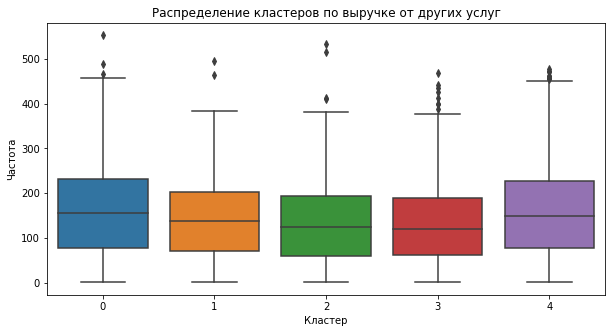

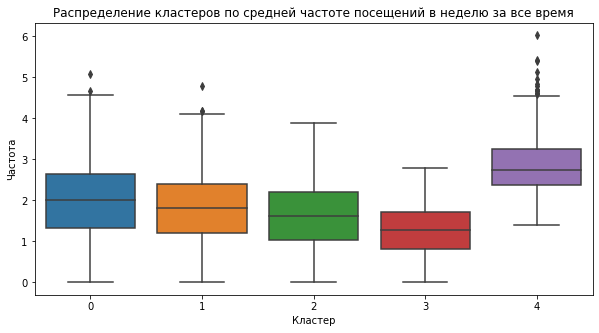

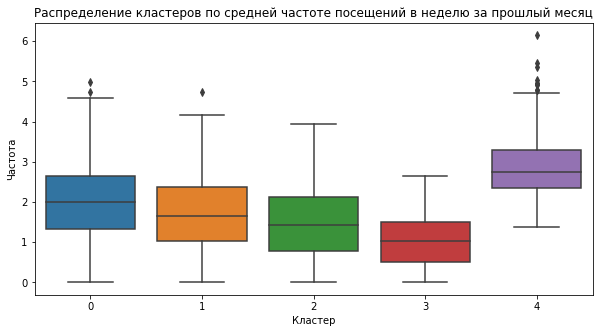

In [13]:
gym_columns2 = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

title_plot2 = ['Распределение кластеров по выручке от других услуг',\
               'Распределение кластеров по средней частоте посещений в неделю за все время',\
               'Распределение кластеров по средней частоте посещений в неделю за прошлый месяц']

count2 = 0

for column in gym_columns2:
    plt.figure(figsize=(10,5))
    plt.title(title_plot2[count2])
    count2 = count2 + 1
    sns.boxplot(data=gym, x='cluster_km', y=column)
    plt.ylabel('Частота')
    plt.xlabel('Кластер')
    plt.show()

**Исходя из графиков, можно отметить:**

* Нет значимых различий между кластерами по половому признаку 
* Клиенты из кластера 2 живут/работают далеко от фитнес-центра, основная масса клиенты остальных кластеров живут/работаю рядом
* Клиенты из кластеров 3 и 4 в основной массе не являются сотрудниками компании-партнера
* Только клиенты из кластера 0 в большей степени учавствовали в акции "Приведи друга"
* Только клиенты из кластера 1 не предоставили свой контактный номер
* В кластере 0 больше всего владельцев годовых абонементов, большинство клиентов кластера 3 купили месячные абонементы
* Не смотря на некоторую долю клиентов в каждом кластере, посещающих групповые занятия, большинство клиентов предпочитают индивидуальные тернировки. Однако, в кластер 0 данная ситуация противоположна.
* В кластере 0 и в кластере 4 средний возраст немного выше остальных.
* Срок до окончания абнемента больше всего у кластера 0 (более 6 мес) и меньше всего у кластера 3 (1 мес)
* Меньше всего приносят выручку от других услуг кластеры 3 и 2
* Кластер 3 и 2 реже всего посещают фитнес-центр.

In [14]:
# для каждого полученного кластера посчитаем долю оттока
gym.groupby('cluster_km')['churn'].mean().reset_index().sort_values(by='churn', ascending=False)

,cluster_km,churn
3,3,0.514263
2,2,0.443564
1,1,0.267532
4,4,0.068019
0,0,0.027723


**Кластер 3 и кластер 2 показывают самый высокий процент оттока. Кластер 0 и кластер 4 являются самыми надежными.**

##  Выводы и рекомендации

**В ходе изучения и предварительной обработки** предоставленных анкет о клиентах сети фитнес-центров данные были проверены на дубликаты и пропуски - не обнаружено, наименования столбцов были приведены к единому стилю, а также столбец 'Month_to_end_contract' был приведен к целочисленному типу.



**В ходе исследовательского анализа можно выделить основные моменты:**
* Клиентами фитнес-центра являются как женщины, так и мужчины, примерно в равном соотношении, средний возраст клиентов - 29 лет
* Большинство клиентов живет/работает рядом с фитнес-цетром
* Большинство клиентов не являются сотрудниками компании-партнера
* 31% клиентов посетили фитнес-центр в рамках акции "Приведи друга"
* 10 % клиентов не указали контакты
* Большинство клиентов приобретают краткосрочные абонементы, в основном на 1 месяц. Срок до окончания абонемента у большинства также 1 мес.
* Большинство клиентов не посещают групповые занятия
* Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
* Среднее время с момента первого обращения в фитнес-центр - более 3 месяцев
* Средняя частота посещений за неделю за все время : 1,8 - 1,9
* Общая доля оттока клиентов составляет 27%
* В результате анализа матрицы корреляций были обнаружены 2 пары признаков с очень высокой корреляцией:'month_to_end_contract' и 'contract_period'(0,97), 'avg_class_frequency_total' и 'avg_class_frequency_current_month'(0,95).

На основании данных была создана модель бинарной классификации клиентов с целевой переменной - факт оттока клиента в следующем месяце, модель была обучена двумя способами: логистической регрессией и случайным лесом. **В результате оценки метрик по каждой модели, модель логистической регресии была признана лучшей**.


**После разбиения клиентов на кластеры можно сделать следующие выводы:**
* **Клиенты Кластера 0** являются самым надежными. Процент оттока менее 3%,в основной массе являются сотрудниками компании-партнера, предпочитают долгосрочные абонементы и групповые занятия, средний возраст немного выше остальных(кроме кластера 4), большинство пришли по акции "Приведи друга", фитнес-центр посещают в среднем 2 раза в неделю, приносят в среднем 161 у.е. выручки от других услуг.
* **Клиенты Кластера 1** являются "пограничными", т.к. имеют средний процент оттока - 26,7. Не являются сотрудниками компании-партнера, не оставляют контактные данные, большинство приобрели абонементы до 6 мес., в среднем посещают 1,8 раз в неделю за все время, при этом приносят среднюю выручку - 144 у.е.
* **Клиенты Кластера 2** находятся в зоне высокого процента оттока - 44,4. Клиенты живут/работают не рядом с фитнес-центром, предпочитают краткосрочные абонементы, чаще всего посещают фитнес-центр 1 раз в неделю, приносят невысокую выручку.
* **Клиенты Кластера 3** являются самыми ненадежными клиентами в связи с высоким процентом оттока - 51,4. Покупают лишь краткосрочные абонементы чаще всего на 1 мес, клиенты данного кластера моложе остальных, в основной массе не являются сотрудниками компании-партнера, ходят не чаще 1 раза в неделю, приносят невысокую выручку.
* **Клиенты Кластера 4** являются надежными клиентами, процент оттока - 6,8. Являются самыми заядлыми спортсменами - посещают фитнес-центр 3 раза в неделю, средний возраст немного выше остальных(кроме кластера 0), приносят в среднем 162 у.е. выручки от других услуг.

**Клиенты Кластера 3 и Кластера 2 являются самыми ненадежными.**

**Рекомендации для взаимодействия с клиентами и их удержания:**
* Необходимо выделить сегмент клиентов, которых однозначно стоит возвращать (в основном клиенты с долгосрочными абонементами и высоким уровнем выручки), для них можно разработать персонализированные предложения.
* Необходимо собрать обратную связь от клиентов, это поможет лучше понять, что вынуждает клиента прекратить посещение, а что заставит пересмотреть свое решение. Можно ввести опросы по средствам рассылки, либо обзвона. Также необходимо мониторить отзывы.
* Любой потребитель любой услуги любит акции и бонусы: необходимо уделять внимание бонусным программам и акциям. Например, при посещении фитнес-клуба более 2-х раза в неделю, получить кислородный коктейль в подарок или при приобретении годового абонемента получить скидку на услуги персонального тренера.
* Можно разработать приложение для клиентов с интересными подборками тренировок, с уведомлениями о проходящих акциях, а также с напоминаниями о посещении фитнес-центра, если клиент допустим не посещал его более 2-х недель. 
* Больше привлекать клиентов к групповым занятиям.